<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/8_Q2Duolingo_preprocessing_studentfeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will look at student based features:
Caveat: we only have data that spans 2 weeks. So we will need to leave the beginning few days out (as they will need to be the basis for the first row)

Also. some of these features will change based on the student's choices. 

1. Average delta (running 3-5 and total)
2. Variance in delta (are they regular?)
2. average words in a day
3. total history correct fraction (basically the mean)
4. number of languages actively learning
5. time active in session - how would we get this?.
6. number of records for this student so far. (session-word pairs)
8. number of records in this day so far?
9. number of new words learned in the last so many days?

Can we cluster students based on profile? Can we use these clusters for predicting if they have forgotten a word or not?

1. Number of records.
2. number of languages learning actively
3. native language
4. learning language
5. average delta
8. std deviation of delta
9. average p_forgot_bin
10. average p_forgot
11. delta after lowest performance session?
12. delta of lowest performance session?
13. delta after highest performance session?
14. delta of highest performance session?
15. average # of sessions logged in per week
16. average words per session. 
17. average length of session

We can try to find learning sessions by clustering by timestamp using DBSCAN. 
All these features are up to the individual timestamps for each record. (cumulative)

First we will get these features for each student. then we will look at how these features help predict performance of two different words. 

There are some issues here because we have some unseen words in the test set. So we will refit when we're ready to get there. 

New plan Jun 25:
Combine with q1 testing dataset. 
Filter to students who have log ins in the last day of the dataset. 

Run models for one word, many students, and see what performance you get (no word features). (delta, history seen, history correct. no session seen included)

Feature engineering:
Get aggregated average from previous days of the dataset. Include feature of number of logins in the last so many days of dataset. 

Run models for one word, many students, and see what performance you get (no word features) - compare with model with only delta, history seen, history correct. 

There's also the one-hot encoding-ish option: get each day's aggregates and make features from those. (14 days * each feature).



In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



In [2]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


Loading q2train dataset:

In [3]:
q2train = decompress_pickle(path_name+"Q2TRAIN.pbz2") 

Quick sanity checks to ensure no duplication after i joined the training and test sets. (There shouldn't be any, but still..)

In [4]:
q2train.duplicated().sum()

0

In [5]:
q2train.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
7,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,0,0.000159,"(es, en)",2013-02-28 20:07:12,5.143600,1.000000
15,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,0,0.000159,"(es, en)",2013-02-28 20:08:50,0.000891,1.000000
20,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,0,0.000159,"(es, en)",2013-02-28 20:11:14,18.921030,0.888889
21,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,0,0.000159,"(es, en)",2013-02-28 20:11:14,19.776609,0.714286
22,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,0,0.000159,"(es, en)",2013-02-28 20:11:14,19.776609,1.000000


In [6]:
q2train['Date'] = q2train['Datetime'].dt.date

There are no ones. We have basically got the all zero baseline. 

This set of features does not suffice to predict student performance. 

Previously we tried a many-word one student model and were able to achieve 0.78 precision with 0.87 recall. This points to student based features being more important than word based features to predicting forgetting a word. 

Plan: 
1. Parse out which students have log ins on the last day of the dataset.
2. Get aggregated student feature data for them alone.
3. split those students into training and testing
4. add those aggregated features to the last date dataset, and split dataset into training and testing.  


Converting timestamp to datetime objects [link](https://stackoverflow.com/questions/9744775/how-to-convert-integer-timestamp-into-a-datetime)

In [7]:
q2train['Date'].describe()

count        9866089
unique            13
top       2013-03-07
freq          909953
Name: Date, dtype: object

Last day is Mar 12, 2013. Let us count the students who logged in that day. 

In [9]:
from datetime import datetime
lastdaylogs = q2train.loc[q2train['Date']==datetime.strptime('12032013', "%d%m%Y").date(),:]

In [10]:
lastdaylogs.shape

(489734, 18)

In [11]:
lastdayusers = lastdaylogs['user_id'].unique()

In [12]:
len(lastdayusers)

11364

Only 11364 students logged in on the last day, with 489734 total records. This is a substantially smaller dataset. I just hope at least some students in the q2 testing set have logged in on the last day if we decide to go with these features. 



Let us split the last day students into training and testing, since we do not want to see the same students in the validation set.  

In [13]:
np.random.seed(123)
lduserstrain = np.random.choice(lastdayusers,int(0.9*len(lastdayusers)),replace=False) # sample from list without replacement
ldusersvalid = set(lastdayusers).difference(lduserstrain)

In [14]:
len(lduserstrain),len(ldusersvalid)

(10227, 1137)

In [15]:
q2train.shape

(9866089, 18)

In [16]:
q2train['Date'].values[0]

datetime.date(2013, 2, 28)

In [17]:
datetime.strptime('12032013',"%d%m%Y").date()

datetime.date(2013, 3, 12)

In [43]:
userdates = q2train.loc[(q2train['Date']!=datetime.strptime('12032013', "%d%m%Y").date()) & \
                         (q2train['user_id'].isin(lastdayusers))].groupby(['user_id','Date']).agg(numseen_day = ('session_seen','sum'), avgp_forgot_day = ('p_forgot_bin','mean'),numwordspracticed_day = ('lexeme_id',lambda x: len(x.unique())), numcorrect_day = ('session_correct','sum'), numquizzes_day = ('session_seen','count'), avgdelta_day = ('delta','mean'), avgactivesessions = ('timestamp',lambda x: len(x.unique())), 
                                     mintimestamp = ('timestamp','min'),maxtimestamp = ('timestamp','max'))

In [44]:
userdates

numseen_day  avgp_forgot_day  numwordspracticed_day  \
user_id Date                                                              
u:-Md   2013-03-02          150         0.200000                     40   
        2013-03-03           58         0.384615                     13   
        2013-03-04           68         0.238095                     14   
        2013-03-05           43         0.333333                      3   
        2013-03-08           92         0.064516                     34   
...                         ...              ...                    ...   
u:zBA   2013-03-10           45         0.000000                     26   
        2013-03-11          171         0.262626                     83   
u:zT8   2013-03-05           29         0.038462                     26   
u:zfs   2013-03-11           39         0.080000                     25   
u:zpJ   2013-03-10           18         0.142857                      7   

                    numcorrect_day  numquizzes_day  avgdelta_day  \
user_id Date                                                       
u:-Md   2013-03-02             140              40  6.453903e+05   
        2013-03-03              52              13  3.344615e+02   
        2013-03-04              63              21  6.039000e+04   
        2013-03-05              41               6  1.128245e+05   
        2013-03-08              88              62  6.252394e+04   
...                            ...             ...           ...   
u:zBA   2013-03-10              45              26  1.352965e+06   
        2013-03-11             145              99  1.296227e+06   
u:zT8   2013-03-05              28              26  5.283672e+06   
u:zfs   2013-03-11              37              25  2.516135e+06   
u:zpJ   2013-03-10              17               7  1.833400e+04   

                    avgactivesessions  mintimestamp  maxtimestamp  
user_id Date                                                       
u:-Md   2013-03-02                  5    1362265480    1362268433  
        2013-03-03                  2    1362268873    1362270267  
        2013-03-04                  3    1362360533    1362361189  
        2013-03-05                  2    1362494998    1362495188  
        2013-03-08                  4    1362709676    1362758874  
...                               ...           ...           ...  
u:zBA   2013-03-10                  1    1362945049    1362945049  
        2013-03-11                  4    1362992278    1363010433  
u:zT8   2013-03-05                  1    1362523860    1362523860  
u:zfs   2013-03-11                  1    1362980193    1362980193  
u:zpJ   2013-03-10                  1    1362940066    1362940066  

[31434 rows x 9 columns]

In [45]:
userdates['duration'] = userdates['maxtimestamp'] - userdates['mintimestamp']
userdates = userdates.drop(['mintimestamp','maxtimestamp'],axis=1)

In [46]:
userdates = userdates.reset_index()
userdates.head()

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration
0,u:-Md,2013-03-02,150,0.200000,40,140,40,645390.300000,5,2953
1,u:-Md,2013-03-03,58,0.384615,13,52,13,334.461538,2,1394
2,u:-Md,2013-03-04,68,0.238095,14,63,21,60390.000000,3,656
3,u:-Md,2013-03-05,43,0.333333,3,41,6,112824.500000,2,190
4,u:-Md,2013-03-08,92,0.064516,34,88,62,62523.935484,4,49198


In [47]:
userdates['lastlogindelta'] = userdates.groupby('user_id')['Date'].shift(-1)

In [49]:
userdates.head(7)

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration,lastlogindelta
0,u:-Md,2013-03-02,150,0.200000,40,140,40,645390.300000,5,2953,2013-03-03
1,u:-Md,2013-03-03,58,0.384615,13,52,13,334.461538,2,1394,2013-03-04
2,u:-Md,2013-03-04,68,0.238095,14,63,21,60390.000000,3,656,2013-03-05
3,u:-Md,2013-03-05,43,0.333333,3,41,6,112824.500000,2,190,2013-03-08
4,u:-Md,2013-03-08,92,0.064516,34,88,62,62523.935484,4,49198,2013-03-10
5,u:-Md,2013-03-10,251,0.075221,72,234,226,135581.641593,8,60209,2013-03-11
6,u:-Md,2013-03-11,103,0.161765,66,92,68,113820.779412,4,4091,NaN


In [57]:
userdates['days_delta'] = ((userdates['lastlogindelta'] - userdates['Date']))
userdates.head(7)

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration,lastlogindelta,days_delta
0,u:-Md,2013-03-02,150,0.200000,40,140,40,645390.300000,5,2953,2013-03-03,1 days
1,u:-Md,2013-03-03,58,0.384615,13,52,13,334.461538,2,1394,2013-03-04,1 days
2,u:-Md,2013-03-04,68,0.238095,14,63,21,60390.000000,3,656,2013-03-05,1 days
3,u:-Md,2013-03-05,43,0.333333,3,41,6,112824.500000,2,190,2013-03-08,3 days
4,u:-Md,2013-03-08,92,0.064516,34,88,62,62523.935484,4,49198,2013-03-10,2 days
5,u:-Md,2013-03-10,251,0.075221,72,234,226,135581.641593,8,60209,2013-03-11,1 days
6,u:-Md,2013-03-11,103,0.161765,66,92,68,113820.779412,4,4091,NaN,NaT


Aggregating the features for each day, and getting mean, variance, and number of days logged in, averag delta day, std dev in delta day

In [61]:
useraggs = userdates.groupby('user_id').describe()

In [62]:
newcolumns = [str(x[0])+'_'+str(x[1]) for x in useraggs.columns]
useraggs.columns = newcolumns

In [63]:
useraggs.head()

,numseen_day_count,numseen_day_mean,numseen_day_std,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_count,avgp_forgot_day_mean,...,duration_75%,duration_max,days_delta_count,days_delta_mean,days_delta_std,days_delta_min,days_delta_25%,days_delta_50%,days_delta_75%,days_delta_max
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Md,7.0,109.285714,71.655924,43.0,63.00,92.0,126.50,251.0,7.0,0.208221,...,26644.5,60209.0,6,1 days 12:00:00,0 days 20:04:47.426292544,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 18:00:00,3 days 00:00:00
u:-TS,4.0,29.000000,11.045361,16.0,25.00,28.5,32.50,43.0,4.0,0.123810,...,449.5,664.0,3,2 days 00:00:00,0 days 00:00:00,2 days 00:00:00,2 days 00:00:00,2 days 00:00:00,2 days 00:00:00,2 days 00:00:00
u:-b,10.0,395.000000,274.475257,63.0,221.25,351.0,501.75,1026.0,10.0,0.119960,...,84985.5,85701.0,9,1 days 02:40:00,0 days 08:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,2 days 00:00:00
u:0P4,2.0,13.000000,15.556349,2.0,7.50,13.0,18.50,24.0,2.0,0.145833,...,117.0,156.0,1,4 days 00:00:00,NaT,4 days 00:00:00,4 days 00:00:00,4 days 00:00:00,4 days 00:00:00,4 days 00:00:00
u:0Q_,9.0,151.111111,103.078180,55.0,80.00,100.0,203.00,328.0,9.0,0.160069,...,3026.0,12735.0,8,1 days 03:00:00,0 days 08:29:07.012947258,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,2 days 00:00:00


In [64]:
useraggs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8087 entries, u:-Md to u:zpJ
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numseen_day_count            8087 non-null   float64
 1   numseen_day_mean             8087 non-null   float64
 2   numseen_day_std              6111 non-null   float64
 3   numseen_day_min              8087 non-null   float64
 4   numseen_day_25%              8087 non-null   float64
 5   numseen_day_50%              8087 non-null   float64
 6   numseen_day_75%              8087 non-null   float64
 7   numseen_day_max              8087 non-null   float64
 8   avgp_forgot_day_count        8087 non-null   float64
 9   avgp_forgot_day_mean         8087 non-null   float64
 10  avgp_forgot_day_std          6111 non-null   float64
 11  avgp_forgot_day_min          8087 non-null   float64
 12  avgp_forgot_day_25%          8087 non-null   float64
 13  avgp_forgot_day_50

The standard deviation columns have null values. days_delta columns also have some null values (single log ins). the rest are fully filled. 

Since we already have min, 25%, median and 75th percentile values, the 'std' columns are deleted. 

we can also delete all but one count columns.

In [71]:
columns_with_na = [col for col in useraggs.columns if useraggs[col].isna().any()]
columns_with_na

['numseen_day_std',
 'avgp_forgot_day_std',
 'numwordspracticed_day_std',
 'numcorrect_day_std',
 'numquizzes_day_std',
 'avgdelta_day_std',
 'avgactivesessions_std',
 'duration_std',
 'days_delta_mean',
 'days_delta_std',
 'days_delta_min',
 'days_delta_25%',
 'days_delta_50%',
 'days_delta_75%',
 'days_delta_max']

In [73]:
useraggs = useraggs.drop(columns_with_na,axis=1)

KeyError: ignored

In [74]:
useraggs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8087 entries, u:-Md to u:zpJ
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numseen_day_count            8087 non-null   float64
 1   numseen_day_mean             8087 non-null   float64
 2   numseen_day_min              8087 non-null   float64
 3   numseen_day_25%              8087 non-null   float64
 4   numseen_day_50%              8087 non-null   float64
 5   numseen_day_75%              8087 non-null   float64
 6   numseen_day_max              8087 non-null   float64
 7   avgp_forgot_day_count        8087 non-null   float64
 8   avgp_forgot_day_mean         8087 non-null   float64
 9   avgp_forgot_day_min          8087 non-null   float64
 10  avgp_forgot_day_25%          8087 non-null   float64
 11  avgp_forgot_day_50%          8087 non-null   float64
 12  avgp_forgot_day_75%          8087 non-null   float64
 13  avgp_forgot_day_ma

In [75]:
countcols = [col for col in useraggs if col.endswith('_count')]
countcols

['numseen_day_count',
 'avgp_forgot_day_count',
 'numwordspracticed_day_count',
 'numcorrect_day_count',
 'numquizzes_day_count',
 'avgdelta_day_count',
 'avgactivesessions_count',
 'duration_count',
 'days_delta_count']

In [76]:
useraggs = useraggs.drop(countcols[:-1],axis=1)
useraggs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8087 entries, u:-Md to u:zpJ
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numseen_day_mean            8087 non-null   float64
 1   numseen_day_min             8087 non-null   float64
 2   numseen_day_25%             8087 non-null   float64
 3   numseen_day_50%             8087 non-null   float64
 4   numseen_day_75%             8087 non-null   float64
 5   numseen_day_max             8087 non-null   float64
 6   avgp_forgot_day_mean        8087 non-null   float64
 7   avgp_forgot_day_min         8087 non-null   float64
 8   avgp_forgot_day_25%         8087 non-null   float64
 9   avgp_forgot_day_50%         8087 non-null   float64
 10  avgp_forgot_day_75%         8087 non-null   float64
 11  avgp_forgot_day_max         8087 non-null   float64
 12  numwordspracticed_day_mean  8087 non-null   float64
 13  numwordspracticed_day_min   8087 

In [77]:
useraggs.head()

,numseen_day_mean,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_mean,avgp_forgot_day_min,avgp_forgot_day_25%,avgp_forgot_day_50%,...,avgactivesessions_50%,avgactivesessions_75%,avgactivesessions_max,duration_mean,duration_min,duration_25%,duration_50%,duration_75%,duration_max,days_delta_count
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Md,109.285714,43.0,63.00,92.0,126.50,251.0,0.208221,0.064516,0.118493,0.200000,...,4.0,4.50,8.0,16955.857143,190.0,1025.00,2953.0,26644.5,60209.0,6
u:-TS,29.000000,16.0,25.00,28.5,32.50,43.0,0.123810,0.066667,0.123810,0.142857,...,2.0,2.00,2.0,340.750000,0.0,240.75,349.5,449.5,664.0,3
u:-b,395.000000,63.0,221.25,351.0,501.75,1026.0,0.119960,0.030303,0.069311,0.107563,...,11.5,13.75,40.0,50399.400000,241.0,3319.75,76608.5,84985.5,85701.0,9
u:0P4,13.000000,2.0,7.50,13.0,18.50,24.0,0.145833,0.000000,0.072917,0.145833,...,2.0,2.50,3.0,78.000000,0.0,39.00,78.0,117.0,156.0,1
u:0Q_,151.111111,55.0,80.00,100.0,203.00,328.0,0.160069,0.045267,0.128205,0.135593,...,5.0,7.00,10.0,3389.888889,901.0,1197.00,2485.0,3026.0,12735.0,8


Split into training adn validation sets:

In [80]:
lduserstrain = np.random.choice(lastdayusers,int(0.9*len(lastdayusers)),replace=False) # sample from list without replacement

array(['u:bCLM', 'u:jhgP', 'u:fvI5', ..., 'u:i5Kl', 'u:ffYF', 'u:iYJG'],
      dtype=object)

Scale and reduce dimensions:

In [ ]:
lduserstrain = list(lduserstrain)
lduserstrain

In [86]:
useraggs_train = useraggs.loc[useraggs.index.isin(lduserstrain),:]
useraggs_train.shape

(7270, 49)

In [88]:
useraggs_valid = useraggs.loc[useraggs.index.isin(ldusersvalid),:]
useraggs_valid.shape

(807, 49)

,numseen_day_mean,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_mean,avgp_forgot_day_min,avgp_forgot_day_25%,avgp_forgot_day_50%,...,avgactivesessions_50%,avgactivesessions_75%,avgactivesessions_max,duration_mean,duration_min,duration_25%,duration_50%,duration_75%,duration_max,days_delta_count
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Md,109.285714,43.0,63.00,92.0,126.50,251.0,0.208221,0.064516,0.118493,0.200000,...,4.0,4.50,8.0,16955.857143,190.0,1025.00,2953.0,26644.5,60209.0,6
u:-TS,29.000000,16.0,25.00,28.5,32.50,43.0,0.123810,0.066667,0.123810,0.142857,...,2.0,2.00,2.0,340.750000,0.0,240.75,349.5,449.5,664.0,3
u:-b,395.000000,63.0,221.25,351.0,501.75,1026.0,0.119960,0.030303,0.069311,0.107563,...,11.5,13.75,40.0,50399.400000,241.0,3319.75,76608.5,84985.5,85701.0,9
u:0P4,13.000000,2.0,7.50,13.0,18.50,24.0,0.145833,0.000000,0.072917,0.145833,...,2.0,2.50,3.0,78.000000,0.0,39.00,78.0,117.0,156.0,1
u:0Q_,151.111111,55.0,80.00,100.0,203.00,328.0,0.160069,0.045267,0.128205,0.135593,...,5.0,7.00,10.0,3389.888889,901.0,1197.00,2485.0,3026.0,12735.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u:yva,43.000000,29.0,36.00,43.0,50.00,57.0,0.090909,0.000000,0.045455,0.090909,...,1.0,1.00,1.0,0.000000,0.0,0.00,0.0,0.0,0.0,1
u:zBA,86.200000,33.0,45.00,47.0,135.00,171.0,0.228556,0.000000,0.144578,0.262626,...,1.0,3.00,4.0,8480.000000,0.0,0.00,0.0,18155.0,24245.0,4
u:zT8,29.000000,29.0,29.00,29.0,29.00,29.0,0.038462,0.038462,0.038462,0.038462,...,1.0,1.00,1.0,0.000000,0.0,0.00,0.0,0.0,0.0,0


In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [89]:
stdscaler1 = StandardScaler()
useraggs_train_ss = stdscaler1.fit_transform(useraggs_train)

In [97]:
pca1 = PCA(n_components=0.95)
useraggs_train_pca = pca1.fit_transform(useraggs_train_ss)

In [133]:
useraggs_train_fs1 = pd.DataFrame(useraggs_train_pca,index=useraggs_train.index)
useraggs_train_fs1.head()

,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
u:-Md,0.127393,-1.495098,-0.129914,-1.479190,-0.186888,0.232866,1.173257,0.139215,-0.027836,-0.444000
u:-TS,-3.281979,-0.313702,1.095284,1.013751,0.078747,0.346221,-0.270084,0.125736,0.113592,0.048056
u:-b,15.392381,-2.406379,2.836382,-6.488267,0.357284,-3.406263,-0.881149,0.120492,-1.102887,0.176423
u:0P4,-5.388488,15.133903,13.643155,-3.180903,-1.771047,2.554904,0.072364,0.187306,0.205279,0.335311
u:0Q_,0.688692,-1.220497,0.087708,-0.389928,0.698101,1.977019,0.392829,0.106870,1.006733,-0.777626


In [99]:
pca1.explained_variance_ratio_

array([0.46930846, 0.12592724, 0.10156014, 0.08967233, 0.06784379,
       0.03901993, 0.01803183, 0.01706129, 0.01270667, 0.00965367])

Columns reduced from 49 to 10 for 95% explained variance. 

In [100]:
useraggs_valid_ss = stdscaler1.transform(useraggs_valid)
useraggs_valid_pca = pca1.transform(useraggs_valid_ss)

In [101]:
useraggs_valid_pca.shape

(807, 10)

In [131]:
# get test set and process with PCA
useraggs_valid_fs1 = pd.DataFrame(useraggs_valid_pca,index=useraggs_valid.index)
useraggs_valid_fs1.head()

,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
u:5rg,1.007850,1.046759,1.090562,-1.261320,1.224406,-0.525411,-0.844461,-0.144141,0.125450,0.193096
u:6-4,-3.245414,-0.988251,-0.117149,-0.490571,-0.229327,0.188998,0.881731,0.207729,0.516248,0.367254
u:6L-,0.371013,-1.867772,1.392866,0.283654,0.850858,-0.521491,0.909448,-0.101140,0.524047,0.646321
u:6i1,0.143656,-1.076837,0.307470,1.275097,1.171917,0.301894,-0.395878,-0.871382,0.084863,0.702613
u:7HL,-2.530708,0.352312,-0.831288,-1.145818,1.207482,-0.564166,1.100144,0.828533,1.548722,0.248535


Applying the same transformations on the test set.

In [102]:
q2test = decompress_pickle(path_name+"Q2TEST.pbz2") 

Quick sanity checks to ensure no duplication after i joined the training and test sets. (There shouldn't be any, but still..)

In [103]:
q2test.duplicated().sum()

0

In [104]:
q2test.head()

,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_forgot_bin,simoverdiff,lang_frozenset,Datetime,delta_days,history_frac
64,1362082493,1469,u:g3WM,pt,en,57408f89412af98111a2f87c0ab41b22,tu/tu<prn><tn><p2><mf><sg>,48,48,1,1,0,0.0,"(pt, en)",2013-02-28 20:14:53,0.017002,1.000000
65,1362082493,1469,u:g3WM,pt,en,8414835cb39e4315146a59fefdd6d1c6,tem/ter<vblex><pri><p3><sg>,2,2,2,1,1,0.0,"(pt, en)",2013-02-28 20:14:53,0.017002,1.000000
66,1362082493,1469,u:g3WM,pt,en,ecc3feb8e53ce936cef181dd54e7aaca,temos/ter<vblex><pri><p1><pl>,1,1,1,1,0,0.0,"(pt, en)",2013-02-28 20:14:53,0.017002,1.000000
67,1362082493,2184,u:g3WM,pt,en,8d28ba0fa188f1847571467189846dda,tua/teu<det><pos><f><sg>,4,3,1,1,0,0.0,"(pt, en)",2013-02-28 20:14:53,0.025278,0.750000
68,1362082493,1469,u:g3WM,pt,en,4b3613233b3fede2e3e92ac2ef752bf6,leão/leão<n><m><sg>,9,8,1,1,0,0.0,"(pt, en)",2013-02-28 20:14:53,0.017002,0.888889


In [105]:
q2test['Date'] = q2test['Datetime'].dt.date

There are no ones. We have basically got the all zero baseline. 

This set of features does not suffice to predict student performance. 

Previously we tried a many-word one student model and were able to achieve 0.78 precision with 0.87 recall. This points to student based features being more important than word based features to predicting forgetting a word. 

Plan: 
1. Parse out which students have log ins on the last day of the dataset.
2. Get aggregated student feature data for them alone.
3. split those students into training and testing
4. add those aggregated features to the last date dataset, and split dataset into training and testing.  


Converting timestamp to datetime objects [link](https://stackoverflow.com/questions/9744775/how-to-convert-integer-timestamp-into-a-datetime)

In [106]:
q2test['Date'].describe()

count        1111307
unique            13
top       2013-03-06
freq          106963
Name: Date, dtype: object

Last day is Mar 12, 2013. Let us count the students who logged in that day. 

In [107]:
from datetime import datetime
lastdaylogs_test = q2test.loc[q2test['Date']==datetime.strptime('12032013', "%d%m%Y").date(),:]

In [108]:
lastdaylogs_test.shape

(55134, 18)

In [109]:
lastdayusers_test = lastdaylogs_test['user_id'].unique()

In [110]:
len(lastdayusers_test)

1286

The test set has 1286 students who logged in on the last day. 

Getting aggregate features. 

In [112]:
userdates_test = q2test.loc[(q2test['Date']!=datetime.strptime('12032013', "%d%m%Y").date()) & \
                         (q2test['user_id'].isin(lastdayusers_test))].groupby(['user_id','Date']).agg(numseen_day = ('session_seen','sum'), avgp_forgot_day = ('p_forgot_bin','mean'),numwordspracticed_day = ('lexeme_id',lambda x: len(x.unique())), numcorrect_day = ('session_correct','sum'), numquizzes_day = ('session_seen','count'), avgdelta_day = ('delta','mean'), avgactivesessions = ('timestamp',lambda x: len(x.unique())), 
                                     mintimestamp = ('timestamp','min'),maxtimestamp = ('timestamp','max'))

In [113]:
userdates_test

numseen_day  avgp_forgot_day  numwordspracticed_day  \
user_id Date                                                              
u:-Ou   2013-03-04           50         0.081081                     37   
        2013-03-05           29         0.250000                      8   
u:-f2   2013-03-07           54         0.274510                     37   
        2013-03-08          103         0.170000                     78   
        2013-03-11           75         0.183099                     60   
...                         ...              ...                    ...   
u:vAE   2013-03-07           70         0.133333                     15   
        2013-03-11          159         0.210526                     42   
u:z22   2013-03-01           20         0.000000                      7   
        2013-03-03           19         0.000000                      7   
        2013-03-04          154         0.020833                     50   

                    numcorrect_day  numquizzes_day  avgdelta_day  \
user_id Date                                                       
u:-Ou   2013-03-04              47              37  1.638390e+06   
        2013-03-05              27               8  2.250238e+05   
u:-f2   2013-03-07              40              51  2.850728e+06   
        2013-03-08              86             100  1.125697e+06   
        2013-03-11              61              71  1.953370e+06   
...                            ...             ...           ...   
u:vAE   2013-03-07              66              15  1.193889e+07   
        2013-03-11             147              57  9.598828e+04   
u:z22   2013-03-01              20               7  8.461900e+04   
        2013-03-03              19               7  1.231100e+04   
        2013-03-04             152              96  1.595272e+05   

                    avgactivesessions  mintimestamp  maxtimestamp  
user_id Date                                                       
u:-Ou   2013-03-04                  1    1362369181    1362369181  
        2013-03-05                  1    1362453636    1362453636  
u:-f2   2013-03-07                  3    1362651864    1362652148  
        2013-03-08                  4    1362743640    1362744713  
        2013-03-11                  3    1362995246    1362998159  
...                               ...           ...           ...  
u:vAE   2013-03-07                  2    1362691250    1362692167  
        2013-03-11                 10    1363032286    1363035171  
u:z22   2013-03-01                  1    1362155309    1362155309  
        2013-03-03                  1    1362351153    1362351153  
        2013-03-04                  6    1362414138    1362426937  

[3524 rows x 9 columns]

In [114]:
userdates_test['duration'] = userdates_test['maxtimestamp'] - userdates_test['mintimestamp']
userdates_test = userdates_test.drop(['mintimestamp','maxtimestamp'],axis=1)

In [115]:
userdates_test = userdates_test.reset_index()
userdates_test.head()

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration
0,u:-Ou,2013-03-04,50,0.081081,37,47,37,1.638390e+06,1,0
1,u:-Ou,2013-03-05,29,0.250000,8,27,8,2.250238e+05,1,0
2,u:-f2,2013-03-07,54,0.274510,37,40,51,2.850728e+06,3,284
3,u:-f2,2013-03-08,103,0.170000,78,86,100,1.125697e+06,4,1073
4,u:-f2,2013-03-11,75,0.183099,60,61,71,1.953370e+06,3,2913


In [116]:
userdates_test['lastlogindelta'] = userdates_test.groupby('user_id')['Date'].shift(-1)

In [117]:
userdates_test.head(7)

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration,lastlogindelta
0,u:-Ou,2013-03-04,50,0.081081,37,47,37,1.638390e+06,1,0,2013-03-05
1,u:-Ou,2013-03-05,29,0.250000,8,27,8,2.250238e+05,1,0,NaN
2,u:-f2,2013-03-07,54,0.274510,37,40,51,2.850728e+06,3,284,2013-03-08
3,u:-f2,2013-03-08,103,0.170000,78,86,100,1.125697e+06,4,1073,2013-03-11
4,u:-f2,2013-03-11,75,0.183099,60,61,71,1.953370e+06,3,2913,NaN
5,u:3Ym,2013-03-08,10,0.000000,10,10,10,2.986000e+03,1,0,2013-03-10
6,u:3Ym,2013-03-10,237,0.110465,66,218,172,2.486401e+04,7,4463,2013-03-11


In [118]:
userdates_test['days_delta'] = ((userdates_test['lastlogindelta'] - userdates_test['Date']))
userdates_test.head(7)

,user_id,Date,numseen_day,avgp_forgot_day,numwordspracticed_day,numcorrect_day,numquizzes_day,avgdelta_day,avgactivesessions,duration,lastlogindelta,days_delta
0,u:-Ou,2013-03-04,50,0.081081,37,47,37,1.638390e+06,1,0,2013-03-05,1 days
1,u:-Ou,2013-03-05,29,0.250000,8,27,8,2.250238e+05,1,0,NaN,NaT
2,u:-f2,2013-03-07,54,0.274510,37,40,51,2.850728e+06,3,284,2013-03-08,1 days
3,u:-f2,2013-03-08,103,0.170000,78,86,100,1.125697e+06,4,1073,2013-03-11,3 days
4,u:-f2,2013-03-11,75,0.183099,60,61,71,1.953370e+06,3,2913,NaN,NaT
5,u:3Ym,2013-03-08,10,0.000000,10,10,10,2.986000e+03,1,0,2013-03-10,2 days
6,u:3Ym,2013-03-10,237,0.110465,66,218,172,2.486401e+04,7,4463,2013-03-11,1 days


Aggregating the features for each day, and getting mean, variance, and number of days logged in, averag delta day, std dev in delta day

In [119]:
useraggs_test = userdates_test.groupby('user_id').describe()

In [120]:
newcolumns = [str(x[0])+'_'+str(x[1]) for x in useraggs_test.columns]
useraggs_test.columns = newcolumns

In [121]:
useraggs_test.head(7)

,numseen_day_count,numseen_day_mean,numseen_day_std,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_count,avgp_forgot_day_mean,...,duration_75%,duration_max,days_delta_count,days_delta_mean,days_delta_std,days_delta_min,days_delta_25%,days_delta_50%,days_delta_75%,days_delta_max
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Ou,2.0,39.500000,14.849242,29.0,34.25,39.5,44.75,50.0,2.0,0.165541,...,0.00,0.0,1,1 days 00:00:00,NaT,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
u:-f2,3.0,77.333333,24.583192,54.0,64.50,75.0,89.00,103.0,3.0,0.209203,...,1993.00,2913.0,2,2 days 00:00:00,1 days 09:56:28.051789035,1 days 00:00:00,1 days 12:00:00,2 days 00:00:00,2 days 12:00:00,3 days 00:00:00
u:3Ym,3.0,84.333333,132.228338,6.0,8.00,10.0,123.50,237.0,3.0,0.092377,...,2231.50,4463.0,2,1 days 12:00:00,0 days 16:58:14.025894517,1 days 00:00:00,1 days 06:00:00,1 days 12:00:00,1 days 18:00:00,2 days 00:00:00
u:3r4,4.0,24.250000,15.861379,12.0,14.25,19.0,29.00,47.0,4.0,0.228865,...,265.25,839.0,3,2 days 00:00:00,1 days 17:34:09.189773951,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,2 days 12:00:00,4 days 00:00:00
u:6OE,5.0,28.200000,4.868265,23.0,26.00,27.0,29.00,36.0,5.0,0.426667,...,0.00,0.0,4,1 days 12:00:00,0 days 23:59:59.999999999,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 12:00:00,3 days 00:00:00
u:9rx,5.0,194.000000,124.943987,63.0,70.00,205.0,313.00,319.0,5.0,0.206328,...,28220.00,41763.0,4,1 days 12:00:00,0 days 13:51:23.063257983,1 days 00:00:00,1 days 00:00:00,1 days 12:00:00,2 days 00:00:00,2 days 00:00:00
u:Arp,7.0,54.428571,34.698017,16.0,28.50,44.0,76.00,112.0,7.0,0.149518,...,66993.50,71900.0,6,1 days 12:00:00,0 days 20:04:47.426292544,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00,1 days 18:00:00,3 days 00:00:00


In [123]:
useraggs_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 904 entries, u:-Ou to u:z22
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numseen_day_count            904 non-null    float64
 1   numseen_day_mean             904 non-null    float64
 2   numseen_day_std              669 non-null    float64
 3   numseen_day_min              904 non-null    float64
 4   numseen_day_25%              904 non-null    float64
 5   numseen_day_50%              904 non-null    float64
 6   numseen_day_75%              904 non-null    float64
 7   numseen_day_max              904 non-null    float64
 8   avgp_forgot_day_count        904 non-null    float64
 9   avgp_forgot_day_mean         904 non-null    float64
 10  avgp_forgot_day_std          669 non-null    float64
 11  avgp_forgot_day_min          904 non-null    float64
 12  avgp_forgot_day_25%          904 non-null    float64
 13  avgp_forgot_day_50%

In [124]:
useraggs_test = useraggs_test.drop(columns_with_na,axis=1)

In [127]:
useraggs_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 904 entries, u:-Ou to u:z22
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numseen_day_count            904 non-null    float64
 1   numseen_day_mean             904 non-null    float64
 2   numseen_day_min              904 non-null    float64
 3   numseen_day_25%              904 non-null    float64
 4   numseen_day_50%              904 non-null    float64
 5   numseen_day_75%              904 non-null    float64
 6   numseen_day_max              904 non-null    float64
 7   avgp_forgot_day_count        904 non-null    float64
 8   avgp_forgot_day_mean         904 non-null    float64
 9   avgp_forgot_day_min          904 non-null    float64
 10  avgp_forgot_day_25%          904 non-null    float64
 11  avgp_forgot_day_50%          904 non-null    float64
 12  avgp_forgot_day_75%          904 non-null    float64
 13  avgp_forgot_day_max

In [ ]:
countcols = [col for col in useraggs if col.endswith('_count')]
countcols

['numseen_day_count',
 'avgp_forgot_day_count',
 'numwordspracticed_day_count',
 'numcorrect_day_count',
 'numquizzes_day_count',
 'avgdelta_day_count',
 'avgactivesessions_count',
 'duration_count',
 'days_delta_count']

In [128]:
useraggs_test = useraggs_test.drop(countcols[:-1],axis=1)
useraggs_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 904 entries, u:-Ou to u:z22
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   numseen_day_mean            904 non-null    float64
 1   numseen_day_min             904 non-null    float64
 2   numseen_day_25%             904 non-null    float64
 3   numseen_day_50%             904 non-null    float64
 4   numseen_day_75%             904 non-null    float64
 5   numseen_day_max             904 non-null    float64
 6   avgp_forgot_day_mean        904 non-null    float64
 7   avgp_forgot_day_min         904 non-null    float64
 8   avgp_forgot_day_25%         904 non-null    float64
 9   avgp_forgot_day_50%         904 non-null    float64
 10  avgp_forgot_day_75%         904 non-null    float64
 11  avgp_forgot_day_max         904 non-null    float64
 12  numwordspracticed_day_mean  904 non-null    float64
 13  numwordspracticed_day_min   904 no

In [129]:
useraggs_test.head()

,numseen_day_mean,numseen_day_min,numseen_day_25%,numseen_day_50%,numseen_day_75%,numseen_day_max,avgp_forgot_day_mean,avgp_forgot_day_min,avgp_forgot_day_25%,avgp_forgot_day_50%,...,avgactivesessions_50%,avgactivesessions_75%,avgactivesessions_max,duration_mean,duration_min,duration_25%,duration_50%,duration_75%,duration_max,days_delta_count
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Ou,39.500000,29.0,34.25,39.5,44.75,50.0,0.165541,0.081081,0.123311,0.165541,...,1.0,1.00,1.0,0.000000,0.0,0.00,0.0,0.00,0.0,1
u:-f2,77.333333,54.0,64.50,75.0,89.00,103.0,0.209203,0.170000,0.176549,0.183099,...,3.0,3.50,4.0,1423.333333,284.0,678.50,1073.0,1993.00,2913.0,2
u:3Ym,84.333333,6.0,8.00,10.0,123.50,237.0,0.092377,0.000000,0.055233,0.110465,...,1.0,4.00,7.0,1487.666667,0.0,0.00,0.0,2231.50,4463.0,2
u:3r4,24.250000,12.0,14.25,19.0,29.00,47.0,0.228865,0.000000,0.083333,0.207729,...,2.0,3.25,7.0,245.000000,0.0,50.25,70.5,265.25,839.0,3
u:6OE,28.200000,23.0,26.00,27.0,29.00,36.0,0.426667,0.222222,0.222222,0.444444,...,1.0,1.00,1.0,0.000000,0.0,0.00,0.0,0.00,0.0,4


Scaling and transforming

In [134]:
useraggs_test_ss = stdscaler1.transform(useraggs_test)
useraggs_test_pca = pca1.transform(useraggs_test_ss)
useraggs_test_fs1 = pd.DataFrame(useraggs_test_pca,index=useraggs_test.index)
useraggs_test_fs1.head()

,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
u:-Ou,-3.057527,-0.336601,0.381169,1.109694,0.445063,-0.165018,-0.266562,-0.340528,0.184156,0.256315
u:-f2,-0.120179,1.261717,0.875501,0.882872,1.200987,-1.631557,-0.401921,0.650212,0.113751,-0.002475
u:3Ym,-1.795337,-2.069121,0.883172,0.301349,0.781814,0.652490,-0.944217,-0.642902,0.399871,-0.695112
u:3r4,-4.007896,6.108707,5.451446,-1.819000,-0.308737,1.319460,0.675499,0.780891,1.508472,0.389429
u:6OE,-5.409131,13.513626,8.312700,-4.229609,-0.690932,1.627957,1.881148,0.161339,1.711296,0.688303


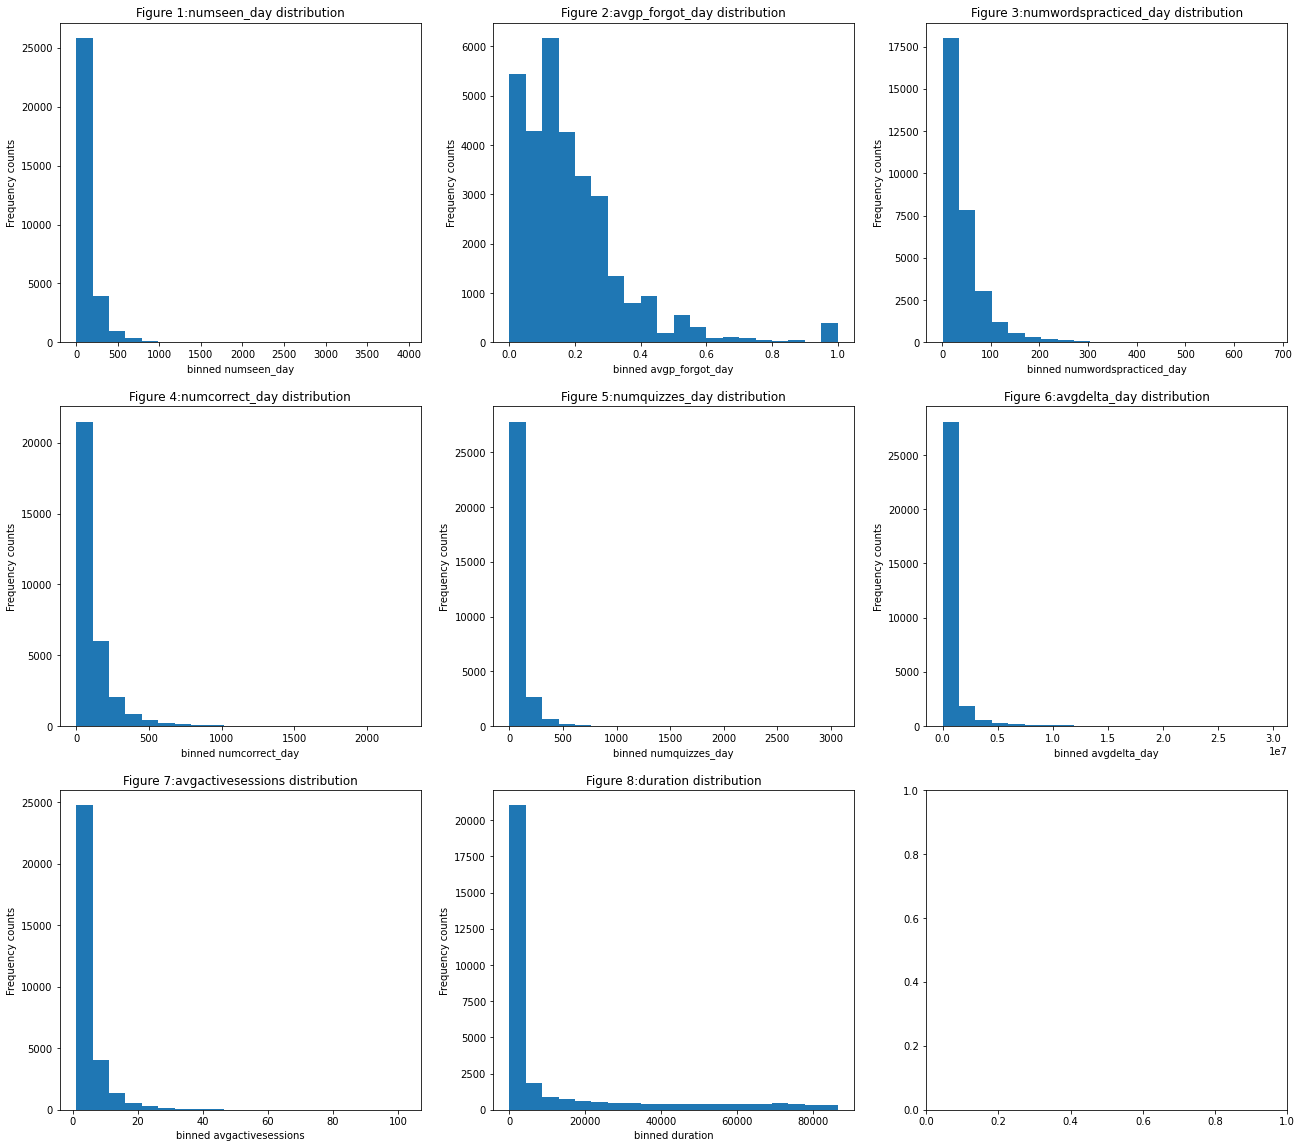

In [ ]:
plt.subplots(3,3,figsize = (22,20))
#plt.suptitle("Distributions of userdates numerical columns")
plot_num = 1
for col in userdates.select_dtypes(exclude= ['object']).columns: # filtering out 'object' datatypes to only numerical columns
  plt.subplot(3,3,plot_num)
  plt.xlabel(f"binned {col}")
  plt.ylabel(f"Frequency counts")
  plt.hist(userdates[col],bins=20)
  plt.title(f"Figure {plot_num}:{col} distribution")
  plot_num +=1

Observations

1. All the columns show distributions heavily skewed to the right. 

They are transformed below to their logarithms, then scaled using minmax scaler. 


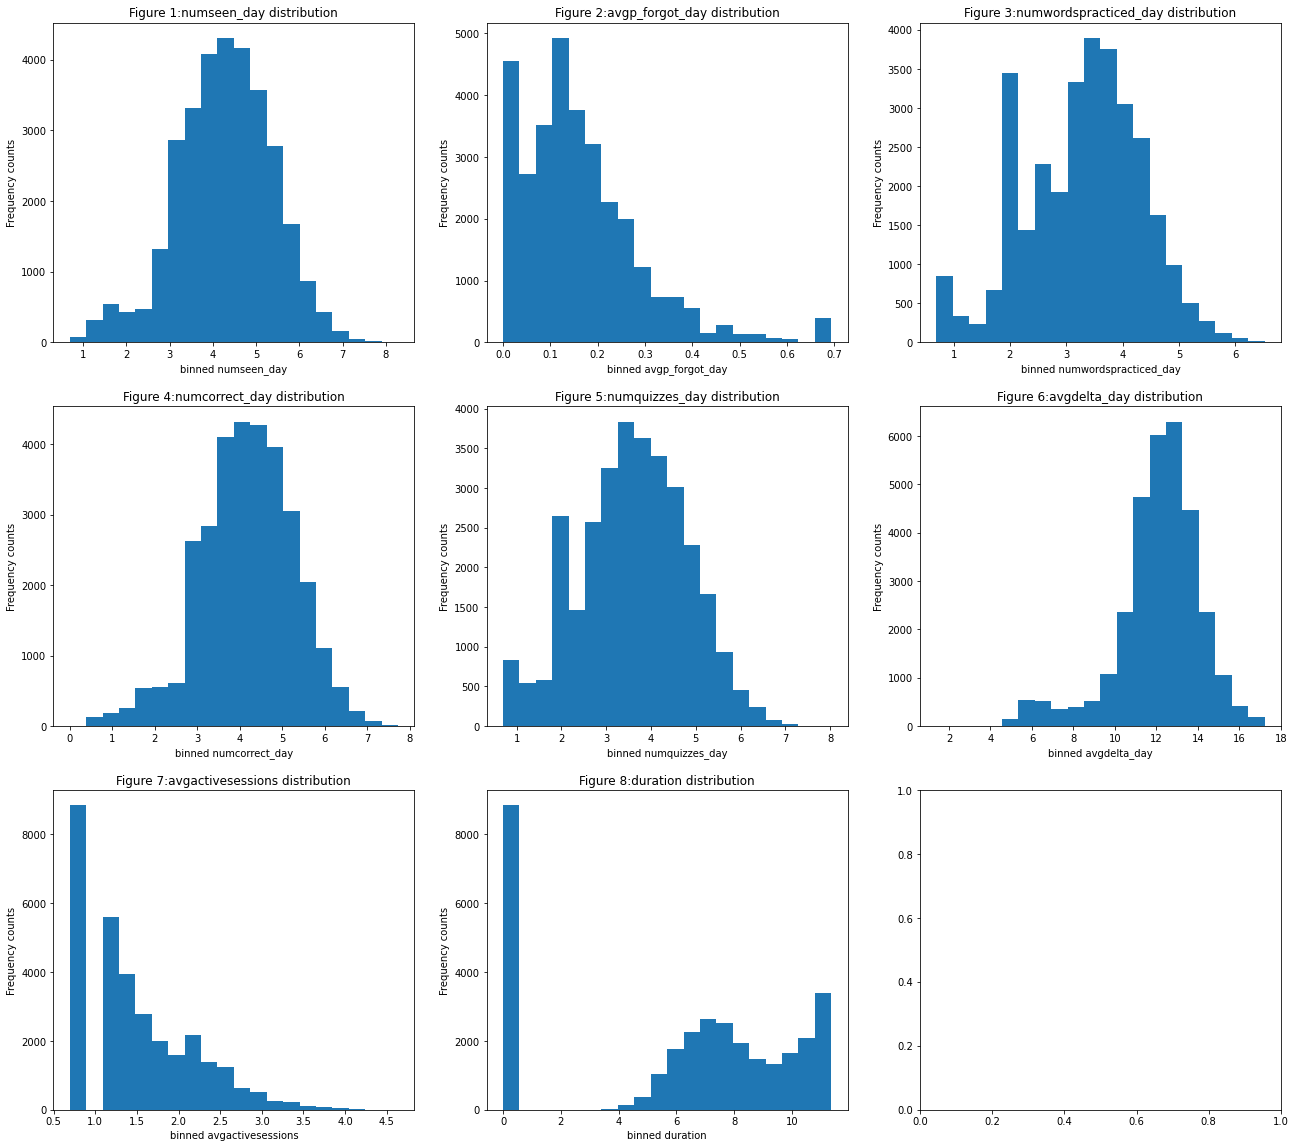

In [ ]:
userdates_tr = userdates.copy()
for col in userdates_tr.columns:
  userdates_tr[col] = np.log(userdates_tr[col]+1)

plt.subplots(3,3,figsize = (22,20))
#plt.suptitle("Distributions of userdates numerical columns")
plot_num = 1
for col in userdates_tr.select_dtypes(exclude= ['object']).columns: # filtering out 'object' datatypes to only numerical columns
  plt.subplot(3,3,plot_num)
  plt.xlabel(f"binned {col}")
  plt.ylabel(f"Frequency counts")
  plt.hist(userdates_tr[col],bins=20)
  plt.title(f"Figure {plot_num}:{col} distribution")
  plot_num +=1

The transformed distributions look a lot more normal shaped. 

The columns are now fit with a minmax scaler. 

Just cluster the average for each user. then scale

In [ ]:
from sklearn.preprocessing import MinMaxScaler 
mmscaler = MinMaxScaler()
userdates_tr_mm = mmscaler.fit_transform(userdates_tr)
userdates_tr_mm = pd.DataFrame(userdates_tr_mm,columns=userdates.columns)
userdates_tr_mm.index = userdates.index

In [ ]:
userdates_tr_mm.head()

numseen_day  avgp_forgot_day  numwordspracticed_day  \
user_id Date                                                              
u:-Md   2013-03-02     0.569916         0.263034               0.518570   
        2013-03-03     0.446059         0.469485               0.334089   
        2013-03-04     0.466695         0.308122               0.345934   
        2013-03-05     0.407396         0.415037               0.119005   
        2013-03-08     0.506036         0.090198               0.491405   

                    numcorrect_day  numquizzes_day  avgdelta_day  \
user_id Date                                                       
u:-Md   2013-03-02        0.640919        0.411839      0.757848   
        2013-03-03        0.514197        0.265327      0.279925   
        2013-03-04        0.538621        0.326956      0.608126   
        2013-03-05        0.484070        0.170816      0.647626   
        2013-03-08        0.581328        0.470410      0.610321   

                    avgactivesessions  duration  
user_id Date                                     
u:-Md   2013-03-02           0.278724  0.703037  
        2013-03-03           0.102869  0.637029  
        2013-03-04           0.175855  0.570783  
        2013-03-05           0.102869  0.462093  
        2013-03-08           0.232468  0.950498

In [ ]:
studentfeatures1 = userdates_tr_mm.transpose().stack().fillna(0)

In [ ]:
studentfeatures1

user_id                    u:-Md     u:-TS      u:-b     u:0P4     u:0Q_  \
            Date                                                           
numseen_day 2013-02-28  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-01  0.000000  0.000000  0.456781  0.000000  0.000000   
            2013-03-02  0.569916  0.000000  0.743598  0.000000  0.487828   
            2013-03-03  0.446059  0.000000  0.822591  0.000000  0.516912   
            2013-03-04  0.466695  0.356918  0.559003  0.000000  0.450453   
...                          ...       ...       ...       ...       ...   
duration    2013-03-07  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-08  0.950498  0.508042  0.773109  0.000000  0.670164   
            2013-03-09  0.000000  0.000000  0.999127  0.000000  0.699945   
            2013-03-10  0.968267  0.571848  0.996958  0.000000  0.831599   
            2013-03-11  0.731707  0.000000  0.999181  0.444846  0.705185   

user_id                    u:0Tt  u:0vf     u:1Qq  u:1kO     u:1nJ  ...  \
            Date                                                    ...   
numseen_day 2013-02-28  0.000000    0.0  0.000000    0.0  0.000000  ...   
            2013-03-01  0.000000    0.0  0.519497    0.0  0.000000  ...   
            2013-03-02  0.000000    0.0  0.446059    0.0  0.000000  ...   
            2013-03-03  0.000000    0.0  0.000000    0.0  0.000000  ...   
            2013-03-04  0.000000    0.0  0.000000    0.0  0.000000  ...   
...                          ...    ...       ...    ...       ...  ...   
duration    2013-03-07  0.000000    0.0  0.613940    0.0  0.000000  ...   
            2013-03-08  0.000000    0.0  0.000000    0.0  0.000000  ...   
            2013-03-09  0.390862    0.0  0.000000    0.0  0.000000  ...   
            2013-03-10  0.000000    0.0  0.000000    0.0  0.000000  ...   
            2013-03-11  0.000000    0.0  0.000000    0.0  0.595286  ...   

user_id                    u:yQy     u:yih     u:yki     u:ylS     u:ynP  \
            Date                                                           
numseen_day 2013-02-28  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-01  0.000000  0.000000  0.212122  0.000000  0.274068   
            2013-03-02  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-03  0.000000  0.000000  0.484533  0.000000  0.000000   
            2013-03-04  0.000000  0.462818  0.426855  0.236152  0.410358   
...                          ...       ...       ...       ...       ...   
duration    2013-03-07  0.682122  0.506388  0.000000  0.000000  0.650618   
            2013-03-08  0.658767  0.536506  0.945455  0.000000  0.000000   
            2013-03-09  0.494161  0.000000  0.954701  0.000000  0.000000   
            2013-03-10  0.000000  0.000000  0.000000  0.000000  0.000000   
            2013-03-11  0.000000  0.391891  0.000000  0.000000  0.529299   

user_id                 u:yva     u:zBA  u:zT8  u:zfs  u:zpJ  
            Date                                              
numseen_day 2013-02-28    0.0  0.000000    0.0    0.0    0.0  
            2013-03-01    0.0  0.000000    0.0    0.0    0.0  
            2013-03-02    0.0  0.418864    0.0    0.0    0.0  
            2013-03-03    0.0  0.000000    0.0    0.0    0.0  
            2013-03-04    0.0  0.000000    0.0    0.0    0.0  
...                       ...       ...    ...    ...    ...  
duration    2013-03-07    0.0  0.000000    0.0    0.0    0.0  
            2013-03-08    0.0  0.000000    0.0    0.0    0.0  
            2013-03-09    0.0  0.000000    0.0    0.0    0.0  
            2013-03-10    0.0  0.000000    0.0    0.0    0.0  
            2013-03-11    0.0  0.862794    0.0    0.0    0.0  

[96 rows x 8087 columns]

In [ ]:
studentfeatures2 = studentfeatures1.transpose()

In [ ]:
studentfeatures2

numseen_day                                                         \
Date     2013-02-28 2013-03-01 2013-03-02 2013-03-03 2013-03-04 2013-03-05   
user_id                                                                      
u:-Md           0.0   0.000000   0.569916   0.446059   0.466695   0.407396   
u:-TS           0.0   0.000000   0.000000   0.000000   0.356918   0.000000   
u:-b            0.0   0.456781   0.743598   0.822591   0.559003   0.610211   
u:0P4           0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
u:0Q_           0.0   0.000000   0.487828   0.516912   0.450453   0.439181   
...             ...        ...        ...        ...        ...        ...   
u:yva           0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
u:zBA           0.0   0.000000   0.418864   0.000000   0.000000   0.556127   
u:zT8           0.0   0.000000   0.000000   0.000000   0.000000   0.356918   
u:zfs           0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
u:zpJ           0.0   0.000000   0.000000   0.000000   0.000000   0.000000   

                                                     ...   duration  \
Date    2013-03-06 2013-03-07 2013-03-08 2013-03-09  ... 2013-03-02   
user_id                                              ...              
u:-Md     0.000000   0.000000   0.506036   0.000000  ...   0.703037   
u:-TS     0.282059   0.000000   0.352450   0.000000  ...   0.000000   
u:-b      0.731363   0.000000   0.673357   0.648449  ...   0.991083   
u:0P4     0.000000   0.053440   0.000000   0.000000  ...   0.000000   
u:0Q_     0.661708   0.000000   0.515601   0.554174  ...   0.623635   
...            ...        ...        ...        ...  ...        ...   
u:yva     0.000000   0.000000   0.000000   0.443806  ...   0.000000   
u:zBA     0.000000   0.373415   0.000000   0.000000  ...   0.000000   
u:zT8     0.000000   0.000000   0.000000   0.000000  ...   0.000000   
u:zfs     0.000000   0.000000   0.000000   0.000000  ...   0.000000   
u:zpJ     0.000000   0.000000   0.000000   0.000000  ...   0.000000   

                                                                           \
Date    2013-03-03 2013-03-04 2013-03-05 2013-03-06 2013-03-07 2013-03-08   
user_id                                                                     
u:-Md     0.637029   0.570783   0.462093   0.000000        0.0   0.950498   
u:-TS     0.000000   0.522382   0.000000   0.000000        0.0   0.508042   
u:-b      0.999327   0.482914   0.646525   0.987806        0.0   0.773109   
u:0P4     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   
u:0Q_     0.687862   0.623341   0.598667   0.731664        0.0   0.670164   
...            ...        ...        ...        ...        ...        ...   
u:yva     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   
u:zBA     0.000000   0.000000   0.888242   0.000000        0.0   0.000000   
u:zT8     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   
u:zfs     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   
u:zpJ     0.000000   0.000000   0.000000   0.000000        0.0   0.000000   

                                          
Date    2013-03-09 2013-03-10 2013-03-11  
user_id                                   
u:-Md     0.000000   0.968267   0.731707  
u:-TS     0.000000   0.571848   0.000000  
u:-b      0.999127   0.996958   0.999181  
u:0P4     0.000000   0.000000   0.444846  
u:0Q_     0.699945   0.831599   0.705185  
...            ...        ...        ...  
u:yva     0.000000   0.000000   0.000000  
u:zBA     0.000000   0.000000   0.862794  
u:zT8     0.000000   0.000000   0.000000  
u:zfs     0.000000   0.000000   0.000000  
u:zpJ     0.000000   0.000000   0.000000  

[8087 rows x 96 columns]

In [ ]:
newcolumns = [str(x[0])+'_'+str(x[1]) for x in studentfeatures2.columns]

In [ ]:
studentfeatures2.columns = newcolumns
studentfeatures2.head()

,numseen_day_2013-02-28,numseen_day_2013-03-01,numseen_day_2013-03-02,numseen_day_2013-03-03,numseen_day_2013-03-04,numseen_day_2013-03-05,numseen_day_2013-03-06,numseen_day_2013-03-07,numseen_day_2013-03-08,numseen_day_2013-03-09,...,duration_2013-03-02,duration_2013-03-03,duration_2013-03-04,duration_2013-03-05,duration_2013-03-06,duration_2013-03-07,duration_2013-03-08,duration_2013-03-09,duration_2013-03-10,duration_2013-03-11
user_id,,,,,,,,,,,,,,,,,,,,,
u:-Md,0.0,0.000000,0.569916,0.446059,0.466695,0.407396,0.000000,0.00000,0.506036,0.000000,...,0.703037,0.637029,0.570783,0.462093,0.000000,0.0,0.950498,0.000000,0.968267,0.731707
u:-TS,0.0,0.000000,0.000000,0.000000,0.356918,0.000000,0.282059,0.00000,0.352450,0.000000,...,0.000000,0.000000,0.522382,0.000000,0.000000,0.0,0.508042,0.000000,0.571848,0.000000
u:-b,0.0,0.456781,0.743598,0.822591,0.559003,0.610211,0.731363,0.00000,0.673357,0.648449,...,0.991083,0.999327,0.482914,0.646525,0.987806,0.0,0.773109,0.999127,0.996958,0.999181
u:0P4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05344,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.444846
u:0Q_,0.0,0.000000,0.487828,0.516912,0.450453,0.439181,0.661708,0.00000,0.515601,0.554174,...,0.623635,0.687862,0.623341,0.598667,0.731664,0.0,0.670164,0.699945,0.831599,0.705185



Now we will join the studentfeatures to the Mar 12 dataset. Then we will join the word features, then split, then convert to sparse arrays.  

In [ ]:
compressed_pickle(path_name+"studentfeatures2",studentfeatures2)

## Clustering

In [ ]:
studentfeatures2.shape

(8087, 96)

In [ ]:
from sklearn.cluster import MiniBatchKMeans



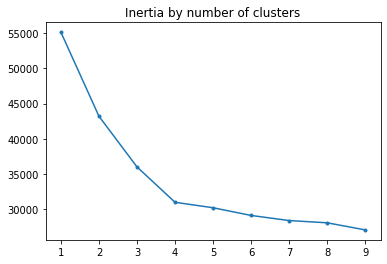

In [ ]:
inertias = []
for k in range(1,10):
  km_model = MiniBatchKMeans(n_clusters=k)
  km_model.fit(studentfeatures2)
  inertias.append(km_model.inertia_)
  
plt.figure()
plt.title("Inertia by number of clusters")
plt.plot(range(1,10),inertias,'.-')
plt.show()

In [ ]:
mbKmeans = MiniBatchKMeans(n_clusters=4)

mbKmeans.fit(studentfeatures2)

studentfeatures2['label'] = mbKmeans.labels_

studentfeatures2['label'].value_counts()

0    3358
1    2984
2    1123
3     622
Name: label, dtype: int64

In [ ]:
from sklearn.metrics import silhouette_score

ks = np.arange(2,10)

sil_scores = []

for k in ks:
    
    kmeans = MiniBatchKMeans(n_clusters = k)
    kmeans.fit(studentfeatures2)
    
    sil_scores.append(silhouette_score(studentfeatures2,kmeans.labels_))
    

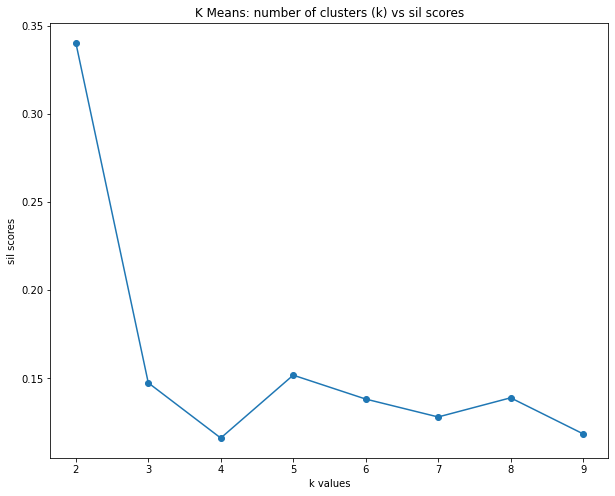

In [ ]:
# plot sil score
plt.figure(figsize = (10,8))
plt.plot(ks,sil_scores,marker = 'o')
plt.xlabel('k values')
plt.ylabel('sil scores')
plt.title('K Means: number of clusters (k) vs sil scores')
plt.show()

Getting Mar 12 dataset

In [ ]:
lastdayq2 = datadfq2.loc[(datadfq2['Date']==datetime.strptime('12032013', "%d%m%Y").date()),:]

In [ ]:
lastdayq2.shape

(492966, 22)

In [ ]:
lastdayq2wstfeatures = pd.merge(left = lastdayq2,right = studentfeatures2,left_on='user_id',right_on = 'user_id',how="left")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [ ]:
lastdayq2wstfeatures.shape

(492966, 142)

Now we get q1lexeme features and attach them, then we get rid of unnecessary columns. then we split by students into train and test. 

In [ ]:
lastdayq2

,p_recall,timestamp,delta,user_id,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,...,"(duration, 2013-03-02)","(duration, 2013-03-03)","(duration, 2013-03-04)","(duration, 2013-03-05)","(duration, 2013-03-06)","(duration, 2013-03-07)","(duration, 2013-03-08)","(duration, 2013-03-09)","(duration, 2013-03-10)","(duration, 2013-03-11)"
0,1.0,1363046401,1123854,u:inBD,4452601308c9aeb4f25f01fb6710ed16,salsa/salsa<n><f><sg>,2,2,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
1,1.0,1363046401,1125308,u:inBD,bdb10c2d4f793986f32986d746051a59,fresas/fresa<n><f><pl>,3,3,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
2,0.0,1363046401,1123854,u:inBD,890f121972386ce1dbb811304e774f3f,comida/comida<n><f><sg>,2,2,1,0,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
3,1.0,1363046401,73543,u:inBD,a52bc2771bde31d4d5e80bd29f350714,manzana/manzana<n><f><sg>,6,6,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
4,1.0,1363046401,1125985,u:inBD,08bb4120ecb09c3cc4a544af3f119f6d,pasta/pasta<n><f><sg>,3,3,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0


numseen_day: how many individual questions were done in the day
avgp_recall_day: the average number of questions answered correctly (should word out to be derivable)
numwordspraciced_day: how many individual words were practiced in that day.
numcorrect_day: how many questions were asnwered correctly in that day
numsessions_day: how many individual sessions


As EDA, we can try to cluster the students based on their behavior. or look at their performance on certain words, and what separates students who forget vs students who don't for around the same delta and history seen. 

For now, we can add the previous learning day's features to each record of the next learning day. if there is none, maybe we can impute the total average although that would be data leakage. maybe do a time based split?

1. get all users up to first 10 days or so, then see if you can predict performance on the next 4 days?

Clustering students:

We may have to look at features for only a subset of the data where we have enough - but this would disproportionately get rid of 'irregular' students. so we shouldn't.

numseen_day: number of questions seen that day
avgp_recall_day - average p_recall per word-session (not the same as numcorrect_day/numseen_day)
numwordspracticed_day: number of unique words practiced that day
numcorrect_day : number of questions answered correctly that day
numquizzes_day: number of quizzes taken per word (number of records that day)
avgdelta_day: the average interval since the last quiz - this is an aggregate measure of the choice made by the student - if avgdelta is low, then they mostly reviewed recent words, if avgdelta is high, then they mostly reviewed words that were learned a while ago. 
avgactivesessions - might be an artefact of how timestamps are recorded, but essentially the number of unique timestamps - if this number is high, student was active during 


In [ ]:
310/446

0.695067264573991

In [ ]:
lexemeids = datadfq1['lexeme_id']
lexemeids = pd.DataFrame(lexemeids)

Getting q1lexemes, getting indices of lexeme id. then joining just those. 

In [ ]:
q1lexemes = decompress_pickle(path_name+"q1_lexeme_features.pbz2")

In [ ]:
q1lexemes.shape

(12160, 2292)

In [ ]:
q1lexemeids=pd.DataFrame(q1lexemes['lexeme_id'])

In [ ]:
q1lexemeids = q1lexemeids.reset_index()
q1lexemeids.head()

,index,lexeme_id
0,0,73eecb492ca758ddab5371cf7b5cca32
1,1,c84476c460737d9fb905dca3d35ec995
2,2,1a913f2ded424985b9c02d0436008511
3,3,38b770e66595fea718366523b4f7db3f
4,4,4bdb859f599fa07dd5eecdab0acc2d34


In [ ]:
lexemeids.shape, q1lexemeids.shape

((7313354, 1), (12160, 2))

Now we will map the main dataframe indices to the lexeme features indices.

In [ ]:
lexeme_map = pd.merge(left=lexemeids,right=q1lexemeids, how='left',left_on = 'lexeme_id',right_on = 'lexeme_id')

In [ ]:
lexeme_map.head()

,lexeme_id,index
0,73eecb492ca758ddab5371cf7b5cca32,0
1,73eecb492ca758ddab5371cf7b5cca32,0
2,c84476c460737d9fb905dca3d35ec995,1
3,1a913f2ded424985b9c02d0436008511,2
4,38b770e66595fea718366523b4f7db3f,3


index column here contains the row of the q1lexemes dataframe that needs to be concatenated to the main dataframe.


Row-wise concatenation using getrow() was taking too long (see below commented cells), so we will instead convert q1lexemes to a coo matrix - > get a dictionary of keys, and use that to construct the bigger matrix. 

There are still some non-numeric columns that need to be converted to binaries or deleted. we will do this first. 

In [ ]:
compressed_pickle(path_name+"lexeme_map",lexeme_map)

In [ ]:
q1lexemes.select_dtypes('object').head()

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings
0,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[]
1,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]"
2,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]"
3,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]"
4,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[]


Converting pos to binaries. 

In [ ]:
pos_dummies = pd.get_dummies(q1lexemes['pos'],prefix='pos')
q1lexemes = pd.concat([q1lexemes,pos_dummies],axis=1)

In [ ]:
q1lexemes['pos']

,pos,pos,pos
0,pr,0.0,0.0
1,n,0.0,0.0
2,vblex,0.0,0.0
3,n,0.0,0.0
4,pr,0.0,0.0
...,...,...,...
12155,vblex,0.0,0.0
12156,n,0.0,0.0
12157,n,0.0,0.0
12158,vblex,0.0,0.0


In [ ]:
q1lexemes['pos1'] = pd.Series([q1lexemes['pos'].loc[i][1] for i in range(q1lexemes['pos'].shape[0])])

In [ ]:
q1lexemes = q1lexemes.drop(['lexeme_id','lexeme_string','learning_language','surface_form','lemma_form','pos','modstrings'],axis=1)

In [ ]:
q1lexemes.select_dtypes('object')

""
0
1
2
3
4
...
12155
12156
12157
12158


No strings left in the q1lexemes dataframe. We can now convert to coo matrix. 

In [ ]:
q1lexemes.size/1000000

27.87072

In [ ]:
q1lexemecoo = coo_matrix(np.array(q1lexemes))

In [ ]:
q1lexemecoo.size/1000000

0.151624

Failed attempt at row-wise concatenation:

In [ ]:
#Very sparse matrix. now we will index a row.
#q1lexemecoo.getrow(0)

#Will go row_wise in lexeme_map, and get the row from the indices, and concatenate. 
# from scipy.sparse import hstack

# lexemes_coo  = q1lexemecoo.getrow(lexeme_map.iloc[0,1])

# for i,row in lexeme_map.tail(-1).iterrows():
#   if i%1000 == 0:
#     print(i,' rows done',end='\r')
#   lexemes_coo = hstack((lexemes_coo,q1lexemecoo.getrow(row['index'])))
# lexemes_coo.shape

<1x2291 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

Converting to dictionary of keys

In [ ]:
q1lexemecoo_dok = q1lexemecoo.todok(copy=True)

Let's look at the first 10 values of the ductionary. 

In [ ]:
list(q1lexemecoo_dok.items())[0:10]

[((0, 0), 7.0),
 ((0, 1), 4.0),
 ((0, 87), 1.0),
 ((0, 141), 0.35263237459267294),
 ((0, 144), 0.4122115155582215),
 ((0, 275), 0.28469397919105377),
 ((0, 276), 0.3929244102341387),
 ((0, 1027), 0.32488787493717813),
 ((0, 2280), 1.0),
 ((1, 0), 20.0)]

We can return the first row as: 

In [ ]:
list(q1lexemecoo_dok[0].items())

[((0, 0), 7.0),
 ((0, 1), 4.0),
 ((0, 87), 1.0),
 ((0, 141), 0.35263237459267294),
 ((0, 144), 0.4122115155582215),
 ((0, 275), 0.28469397919105377),
 ((0, 276), 0.3929244102341387),
 ((0, 1027), 0.32488787493717813),
 ((0, 2280), 1.0)]

We can create a new coo matrix from a dictionary of keys we defined.

In [ ]:
keyvals = [(key,val) for (key,val) in q1lexemecoo_dok[0].items()]
vals = [val for (key,val) in keyvals]
rows = [key[0] for (key,val) in keyvals]
cols = [key[1] for (key,val) in keyvals]

coo = coo_matrix((vals, (rows, cols)))

spmatrix = coo.toarray()
spmatrix

array([[7., 4., 0., ..., 0., 0., 1.]])

add a row to a dictionary, with the row number updated with the main dataframe row. 

In [ ]:
vals = []
rows = []
cols = []

count = 0
for i in lexeme_map['index']:
  if count%1000 == 0:
    print(count," rows done")
  keyvals = [(key,val) for (key,val) in q1lexemecoo_dok[i].items()]
  vals = vals + [val for (key,val) in keyvals]
  cols = cols + [key[1] for (key,val) in keyvals]
  rows = rows + [i]*len(keyvals)
  count +=1 

0  rows done
1000  rows done
2000  rows done
3000  rows done
4000  rows done
5000  rows done
6000  rows done
7000  rows done
8000  rows done
9000  rows done
10000  rows done
11000  rows done
12000  rows done
13000  rows done
14000  rows done
15000  rows done
16000  rows done
17000  rows done
18000  rows done
19000  rows done
20000  rows done
21000  rows done
22000  rows done
23000  rows done
24000  rows done
25000  rows done
26000  rows done
27000  rows done
28000  rows done
29000  rows done
30000  rows done
31000  rows done
32000  rows done
33000  rows done
34000  rows done
35000  rows done
36000  rows done
37000  rows done
38000  rows done
39000  rows done
40000  rows done


KeyboardInterrupt: ignored

We can construct the dictionary so that we use the 'index' column in the main dataframe change the row numbers to match the row of the main dataframe. 

The pseudocode is below:

initialize a dictionary that will be the sparse matrix:
word_features = dict()

For each row in the lexemes dataframe:<br>
  >indexnumbers = Get the rows of the main dataframe with that word from the 'index' column<br>
  >for each number in indexnumbers:<br>
  >>copy the row of q1lexemes, and change the row number to be same as main dataframe row. 
    
Convert the dictionary to a sparse matrix. 

Another alternative is to get counts of p_forgot_bin and number of sessions for each word, and model just the word features. this is another possibility for reducing size: feature selection. 

Pseudocode:
transform delta for finer granularity, and get bins, 
groupby the lexeme_id, and bins and get p_forgot counts for 1 and 0. also num students for each delta? and total? should we also get bin by history correct/ history and group by both delta and fraction history correct? 

table:
lexeme id, lexeme id features, p_forgot_1_counts list, p_forgot_0_counts list, delta_bins_list, history_frac_list 